In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.optimize import curve_fit

In [2]:
class DataSlide:
	def __init__(self, keys, vals):
		self.data = dict(zip(keys, vals))

	def get(self, key):
		if self.data[key].ndim == 1:
			return self.data[key][0]
		else:
			return self.data[key][:,0]
	
	def get_err(self, key):
		if self.data[key].ndim == 1:
			raise KeyError("Data not found")
		else:
			return self.data[key][:,1]

	def get_nruns(self, key):
		if self.data[key].ndim == 1:
			raise KeyError("Data not found")
		else:
			return self.data[key][:,2]

class DataFrame:
	def __init__(self):
		self.params = {}
		self.slides = []
	
	def __add__(self, other):
		new = DataFrame()
		new.params = {**self.params, **other.params}

		for slide in self.slides:
			new.add_dataslide(slide)
		for slide in other.slides:
			new.add_dataslide(slide)

		return new

	def add_dataslide(self, slide):
		self.slides.append(slide)

	def get_property_with_id(self, key, id):
		return self.slides[id][key]

	def get_param(self, key):
		return self.params[key]

	def get(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get(key))
		return np.array(val)
	
	def get_err(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get_err(key))
		return np.array(val)

	def get_nruns(self, key):
		val = []
		for slide in self.slides:
			val.append(slide.get_nruns(key))
		return np.array(val)
	
	def filter(self, key, val):
		new_df = DataFrame()
		new_df.params = self.params.copy()
		for slide in self.slides:
			if np.isclose(slide.get(key), val):
				new_df.add_dataslide(slide)
		
		return new_df

def parse_datafield(s):
	if list(s.keys())[0] == 'Data':
		sample = s[list(s.keys())[0]]
		return np.array(sample)
	else:
		return np.array([s[list(s.keys())[0]]])

def load_data(filename):
	data = DataFrame()
	with open(filename, 'r') as f:
		json_contents = json.load(f)
		for param_key in json_contents['params']:
			data.params[param_key] = parse_datafield(json_contents['params'][param_key])[0]
		for slide in json_contents['slides']:
			keys = list(slide['data'].keys())
			vals = [parse_datafield(slide['data'][key]) for key in keys]
				
			data.add_dataslide(DataSlide(keys, vals))
	
	return data

In [3]:
def plot_run(data: DataFrame, run_id: int, average_interval: int = 1, ax = None):
	if ax is None:
		ax = plt.gca()

	entropy = data.get_property_with_id("entropy", run_id)
	if average_interval != 1:
		times = []
		entropy_avg = []
		for i in range(len(entropy)//average_interval):
			times.append(i*average_interval)
			entropy_avg.append(np.mean(entropy[i*average_interval:(i+1)*average_interval]))
	else:
		entropy_avg = entropy

	ax.plot(entropy_avg)
	ax.set_xlabel(r'$t$', fontsize=16)
	ax.set_ylabel(r'$S_A^2$', fontsize=16)

def plot_all_data(data: DataFrame, ax = None):
	if ax is None:
		ax = plt.gca()

	unique_p = sorted(list(set(data.get('mzr_prob'))))
	unique_LA = sorted(list(set(data.get('partition_size'))))
	entropy = np.zeros((len(unique_p), len(unique_LA)))
	entropy_err = np.zeros((len(unique_p), len(unique_LA)))
	for slide in data.slides:
		i = unique_p.index(slide.get('mzr_prob'))
		j = unique_LA.index(slide.get('partition_size'))

		entropy[i][j] = slide.get('entropy')
		entropy_err[i][j] = slide.get_err('entropy')

	colors = ['C0', 'orange', 'yellow', 'purple', 'green', 'black', 'magenta', 'cyan']
	for n,p in enumerate(unique_p):
		ax.errorbar(unique_LA, entropy[n], yerr=entropy_err[n], linewidth=1.5, marker='*', color=colors[n-1 if 0 in unique_p else n], label=f'p = {p}')

	ax.legend(fontsize=16)
	ax.set_xlabel(r'$L_A$', fontsize=16)
	ax.set_ylabel(r'$\overline{S_A^{(2)}}$', fontsize=16)

def linear(x, a, b):
	return x*a + b
	
def combine_dist(s1, s2):
	(mean1, std1, N1) = s1
	(mean2, std2, N2) = s2

	N3 = N1 + N2
	mean3 = (N1*mean1 + N2*mean2)/N3
	std3 = np.sqrt((N1*(std1**2 + (mean1 - mean3)**2) + N2*(std2**2 + (mean2 - mean3)**2))/N3)

	return (mean3, std3, N3)

def combine_many_dists(dists):
	dists = list(dists)
	dist = dists[0]
	for d in dists[1:]:
		dist = combine_dist(d, dist)
	return dist


def average_data(df: DataFrame):
	entropy_samples = np.array([slide.get('entropy') for slide in df.slides]).T
	entropy_err_samples = np.array([slide.get_err('entropy') for slide in df.slides]).T
	nrun_samples = np.array([slide.get_nruns('entropy') for slide in df.slides]).T

	num_times = len(entropy_samples)
	measurement_freq = df.get_param('measurement_freq')
	equilibration_steps = df.get_param('equilibration_steps')

	S = np.zeros(num_times)
	dS = np.zeros(num_times)
	N = np.zeros(num_times)

	for i in range(num_times):
		(S[i], dS[i], N[i]) = combine_many_dists(zip(entropy_samples[i], entropy_err_samples[i], nrun_samples[i]))
	
	t = np.array([equilibration_steps + (i+1)*measurement_freq for i in range(num_times)])

	return S, dS, N, t


In [4]:
ee_string = r'$\overline{S_A^{(2)}}$'
ee_var_string = r'Var[$S_A^{(2)}$]'


def logx(partition_size, system_size):
	return np.log(np.sin(np.pi*partition_size/system_size)*system_size/np.pi)


# Used by fig4 and fig5
def unpack_slides(data: DataFrame):
	data.slides = sorted(data.slides, key=lambda slide: slide.get('partition_size'))
	num_slides = len(data.slides)

	partition_sizes = np.array([slide.get('partition_size') for slide in data.slides])
	entropy = data.get('entropy').flatten()
	entropy_err = data.get_err('entropy').flatten()

	inds = np.argsort(partition_sizes)
	partition_sizes, entropy, entropy_err = partition_sizes[inds], entropy[inds], entropy_err[inds]

	return partition_sizes, entropy, entropy_err

def truncate_data(x, S, dS):
	max_ind = np.argmax(x)

	return x[:max_ind], S[:max_ind], dS[:max_ind]

suffix2 = "_rc_2"
suffix4 = "_rc_4"


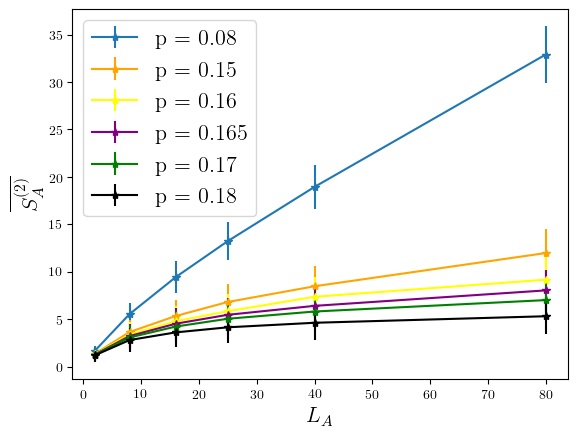

In [60]:
def fig1(filename):
	data = load_data(filename)
	plot_all_data(data)
	plt.show()



#fig1("data/base.json")
#fig1("data/base" + suffix2 + ".json")
fig1("data/base_200_rc_2.json")
#fig1("data/base" + suffix4 + ".json")

Quantum Automaton Circuit:


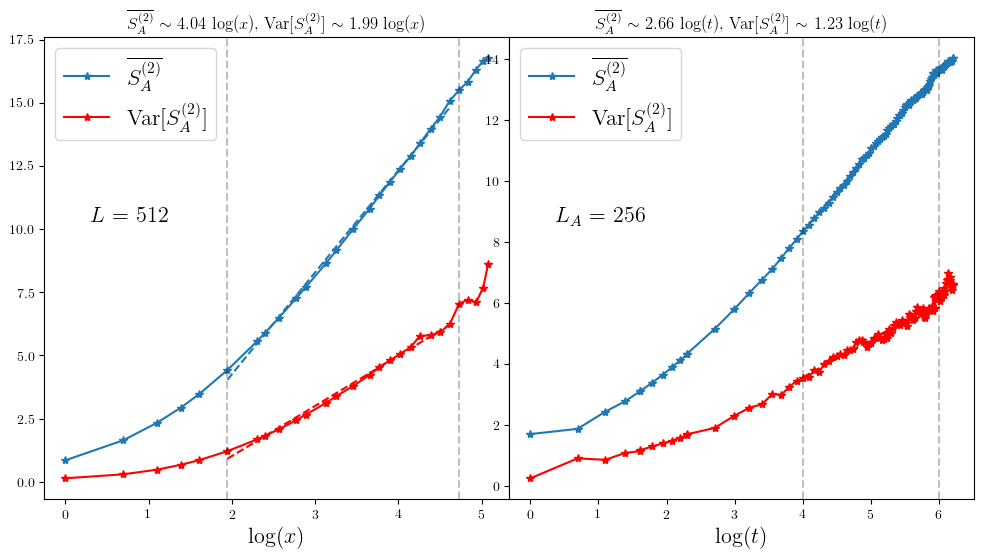

Random Clifford (2) Circuit:


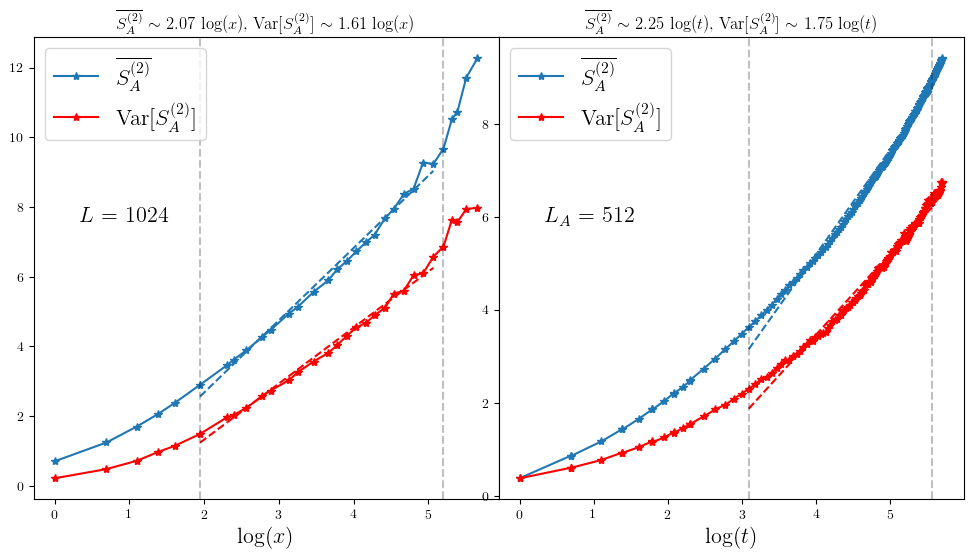

In [6]:
def get_coefficients(timeseries_filenames, fluctuation_filename, mzr_prob = None):
	data_fluc = load_data(fluctuation_filename)
	if mzr_prob is not None:
		data_fluc = data_fluc.filter('mzr_prob', mzr_prob)

	partition_sizes, entropy, entropy_err = unpack_slides(data_fluc)
	entropy_var = entropy_err**2

	system_size = data_fluc.get('system_size')[0]

	log_x = np.array([logx(partition_size, system_size) for partition_size in partition_sizes])
	log_x, entropy, entropy_var = truncate_data(log_x, entropy, entropy_var)

	
	(start, end) = (5, -5)
	a_entropy, y_entropy = curve_fit(linear, log_x[start:end], entropy[start:end])[0]
	a_entropy_var, y_entropy_var = curve_fit(linear, log_x[start:end], entropy_var[start:end])[0]

	fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
	ax[0].plot(log_x, entropy, color='C0', label=ee_string, marker='*')
	ax[0].plot(log_x[start:end], a_entropy*log_x[start:end] + y_entropy, color='C0', linestyle='--')
	ax[0].plot(log_x, entropy_var, color='red', label=ee_var_string, marker='*')
	ax[0].plot(log_x[start:end], a_entropy_var*log_x[start:end] + y_entropy_var, color='red', linestyle='--')
	ax[0].set_title(ee_string + r' $\sim$ ' + f'{a_entropy:.2f}' + r' $\log(x)$, ' + ee_var_string + r' $\sim$ ' + f'{a_entropy_var:.2f}' + r' $\log(x)$', )
	ax[0].set_xlabel(r'$\log(x)$', fontsize=16)
	ax[0].text(0.1, 0.6, r"$L$" + f" = {data_fluc.get('system_size')[0]}", transform=ax[0].transAxes, fontsize=16)
	ax[0].legend(fontsize=16)

	ax[0].axvline(log_x[end], linestyle='--', color='k', alpha=0.25)
	ax[0].axvline(log_x[start], linestyle='--', color='k', alpha=0.25)

	if mzr_prob is None:
		data = [average_data(load_data(f)) for f in timeseries_filenames]
	else:
		data = [average_data(load_data(f).filter('mzr_prob', mzr_prob)) for f in timeseries_filenames]

	entropy, entropy_err, N, t = [np.concatenate(tuple(val[i] for val in data)) for i in range(4)]
	inds = np.argsort(t)
	entropy, entropy_var, N, t = entropy[inds], entropy_err[inds]**2, N[inds], t[inds]
	log_t = np.log(t)

	(start, end) = (20, -20)
	a_entropy, y_entropy = curve_fit(linear, log_t[start:end], entropy[start:end])[0]
	a_entropy_var, y_entropy_var = curve_fit(linear, log_t[start:end], entropy_var[start:end])[0]

	ax[1].plot(log_t, entropy, color='C0', label=ee_string, marker='*')
	ax[1].plot(log_t[start:end], a_entropy*log_t[start:end] + y_entropy, color='C0', linestyle='--')
	ax[1].plot(log_t, entropy_var, color='red', label=ee_var_string, marker='*')
	ax[1].plot(log_t[start:end], a_entropy_var*log_t[start:end] + y_entropy_var, color='red', linestyle='--')
	ax[1].set_title(ee_string + r' $\sim$ ' + f'{a_entropy:.2f}' + r' $\log(t)$, ' + ee_var_string + r' $\sim$ ' + f'{a_entropy_var:.2f}' + r' $\log(t)$', )
	ax[1].set_xlabel(r'$\log(t)$', fontsize=16)
	ax[1].text(0.1, 0.6, r"$L_A$" + f" = {load_data(timeseries_filenames[0]).get('partition_size')[0]}", transform=ax[1].transAxes, fontsize=16)
	ax[1].legend(fontsize=16)
	
	ax[1].axvline(log_t[end], linestyle='--', color='k', alpha=0.25)
	ax[1].axvline(log_t[start], linestyle='--', color='k', alpha=0.25)

	plt.subplots_adjust(wspace=0)
	plt.show()

print("Quantum Automaton Circuit:")
get_coefficients(["data/timeseries.json", "data/timeseries_small.json"], "data/fluctuations.json")
print("Random Clifford (2) Circuit:")
get_coefficients(["data/timeseries_1024" + suffix2 + ".json", "data/timeseries_small_1024" + suffix2 + ".json"], "data/fluctuations_1024" + suffix2 + ".json")
#print("Random Clifford (4) Circuit:")
#get_coefficients(["data/timeseries" + suffix4 + ".json", "data/timeseries_small" + suffix4 + ".json"], "data/fluctuations" + suffix4 + ".json")
	

In [66]:
data = load_data('data/fluctuations.json')
partition_sizes = data.get('partition_size')

partition_sizes, entropy, entropy_err = combine_slides(data)
system_size = data.get('system_size')[0]

log_x = logx(partition_sizes, system_size)

log_x, entropy, entropy_err = truncate_data(log_x, entropy, entropy_err)

fig, ax = plt.subplots(figsize=(12,9))
plt.plot(log_x, entropy, label='Eliot')
start, stop = 5, 20
a_entropy, y_entropy = curve_fit(linear, log_x[start:stop], entropy[start:stop])[0]
print(a_entropy)
plt.plot(L200[:,0], L200[:,1], label='Xiao')
plt.plot(log_x[start:stop], log_x[start:stop]*a_entropy + y_entropy, 'r--')
plt.legend()
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'data/fluctuations.json'

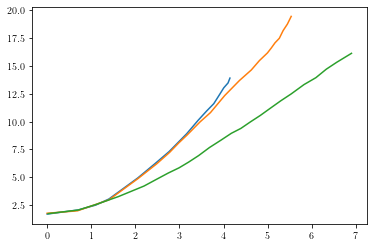

In [13]:
logt = \
	np.array([[0.01617250673854409, 1.7153284671532845],
	[0.7061994609164417, 2.0437956204379546],
	[1.1159029649595684, 2.5547445255474486],
	[1.6118598382749325, 3.248175182481752],
	[2.1940700808625335, 4.197080291970803],
	[2.4851752021563343, 4.817518248175183],
	[2.743935309973046, 5.3649635036496335],
	[2.991913746630728, 5.839416058394161],
	[3.2075471698113196, 6.350364963503651],
	[3.433962264150944, 6.9343065693430646],
	[3.6819407008086245, 7.664233576642337],
	[3.940700808625336, 8.321167883211679],
	[4.177897574123989, 8.941605839416058],
	[4.393530997304581, 9.37956204379562],
	[4.6091644204851745, 9.963503649635035],
	[4.835579514824797, 10.54744525547445],
	[5.040431266846361, 11.131386861313867],
	[5.2991913746630726, 11.861313868613136],
	[5.5363881401617245, 12.481751824817517],
	[5.827493261455525, 13.321167883211679],
	[6.097035040431266, 13.941605839416058],
	[6.334231805929918, 14.708029197080291],
	[6.57142857142857, 15.32846715328467],
	[6.9056603773584895, 16.131386861313867]])

L200 = \
	np.array([[-0.005390835579515141, 1.6788321167883247],
	[0.6954177897574119, 2.0437956204379546],
	[1.0943396226415092, 2.4817518248175183],
	[1.3962264150943393, 3.0291970802919685],
	[2.053908355795148, 4.92700729927007],
	[2.474393530997304, 6.313868613138688],
	[2.7654986522911047, 7.299270072992702],
	[3.164420485175201, 8.905109489051094],
	[3.423180592991913, 10.109489051094888],
	[3.617250673854448, 10.94890510948905],
	[3.7789757412398917, 11.605839416058393],
	[3.9191374663072773, 12.481751824817517],
	[4.005390835579514, 13.02919708029197],
	[4.1024258760107815, 13.467153284671532],
	[4.1455525606469, 13.905109489051094]])

L800 = \
	np.array([[-0.005390835579515141, 1.7518248175182478],
	[0.6846361185983825, 1.9708029197080315],
	[1.3962264150943393, 2.9562043795620454],
	[2.0646900269541772, 4.89051094890511],
	[2.4851752021563343, 6.204379562043794],
	[2.776280323450135, 7.226277372262775],
	[2.981132075471697, 8.065693430656934],
	[3.1752021563342323, 8.795620437956204],
	[3.4663072776280313, 9.963503649635035],
	[3.703504043126684, 10.802919708029197],
	[4.026954177897574, 12.335766423357663],
	[4.361185983827493, 13.686131386861312],
	[4.630727762803234, 14.635036496350363],
	[4.814016172506738, 15.474452554744524],
	[4.997304582210242, 16.16788321167883],
	[5.083557951482479, 16.605839416058394],
	[5.169811320754716, 17.080291970802918],
	[5.2668463611859835, 17.481751824817515],
	[5.35309973045822, 18.175182481751822],
	[5.450134770889488, 18.75912408759124],
	[5.5363881401617245, 19.452554744525546]])

plt.plot(L200[:,0], L200[:,1], label='L = 200')
plt.plot(L800[:,0], L800[:,1], label='L = 800')
plt.plot(logt[:,0], logt[:,1])
plt.show()

def fit(data, start, stop):
	return curve_fit(linear, data[start:stop,0], data[start:stop,1])[0]




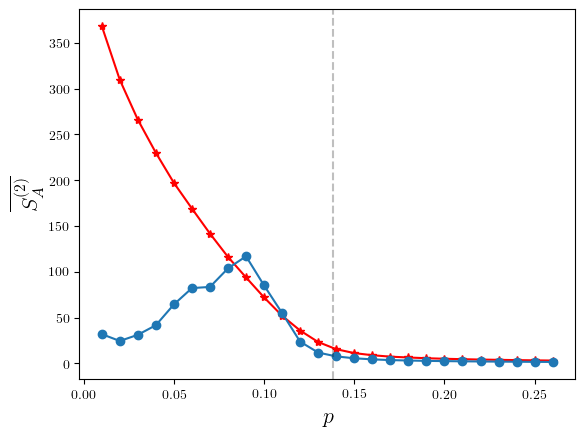

In [11]:
data = load_data('data/transition_1024.json')
pc = 0.138

mzr_probs = data.get('mzr_prob')
entropy = data.get('entropy')
entropy_err = data.get_err('entropy')

plt.plot(mzr_probs, entropy, 'r', marker='*')
plt.plot(mzr_probs, entropy_err**2, marker='o')
plt.axvline(pc, linestyle='--', color='k', alpha=0.25)
plt.xlabel(r'$p$', fontsize=16)
plt.ylabel(ee_string, fontsize=16)
plt.show()